In [1]:
import numpy as np
import pandas as pd
import os
import gym
import random
from gym import spaces
import torch
import matplotlib.pyplot as plt
from Environment import DiagnosisEnv
from Agent import train_DQN

In [2]:
df_symptoms = pd.read_csv("Data/Symptoms.csv")
df_exams = pd.read_csv("Data/Examinations.csv")
df_emergency_diagnoses = pd.read_csv("Data/Emergency_Diagnosis.csv")
df_gen_surgery_diagnoses = pd.read_csv("Data/Gen_Surgery_Diagnosis.csv")
df_neuro_diagnoses = pd.read_csv("Data/Neuro_Diagnosis.csv")

In [3]:
df_combined = pd.concat([df_emergency_diagnoses,df_gen_surgery_diagnoses,df_neuro_diagnoses])

In [4]:
env = DiagnosisEnv(df_symptoms, df_exams, df_combined)
agent, rewards, success_rates, examinations_per_diagnosis = train_DQN(env, episodes=5000)

C:\Users\jerem\Project_Hospital\Agent.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return (torch.tensor(state, dtype=torch.float32),


In [5]:
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

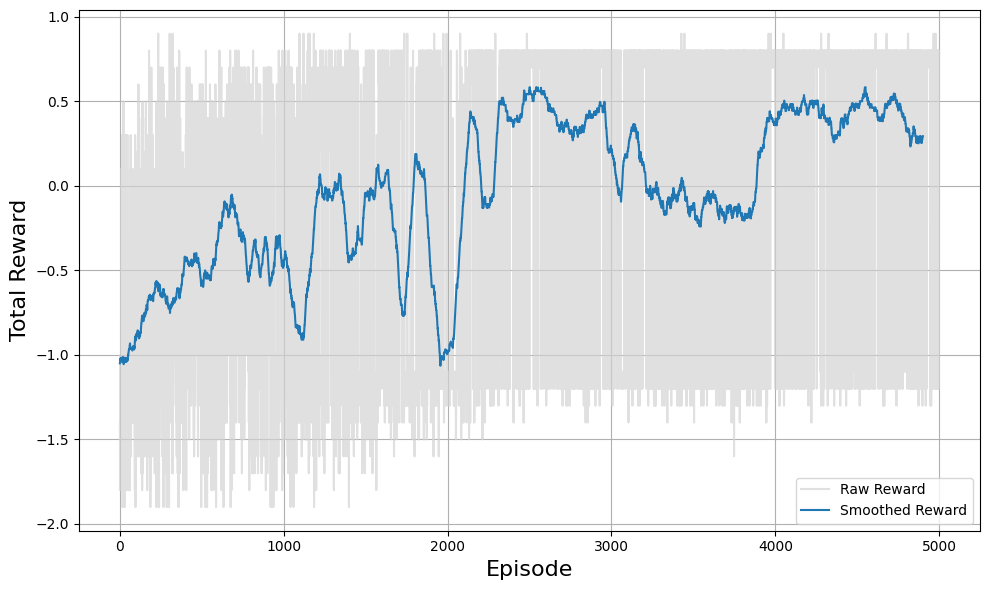

In [6]:
smoothed_rewards = moving_average(rewards, window_size=100)
plt.figure(figsize=(10,6))
plt.plot(rewards, color="lightgray", label="Raw Reward", alpha=0.7)
plt.plot(range(len(smoothed_rewards)), smoothed_rewards, label="Smoothed Reward")
plt.xlabel("Episode", fontsize=16)
plt.ylabel("Total Reward", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

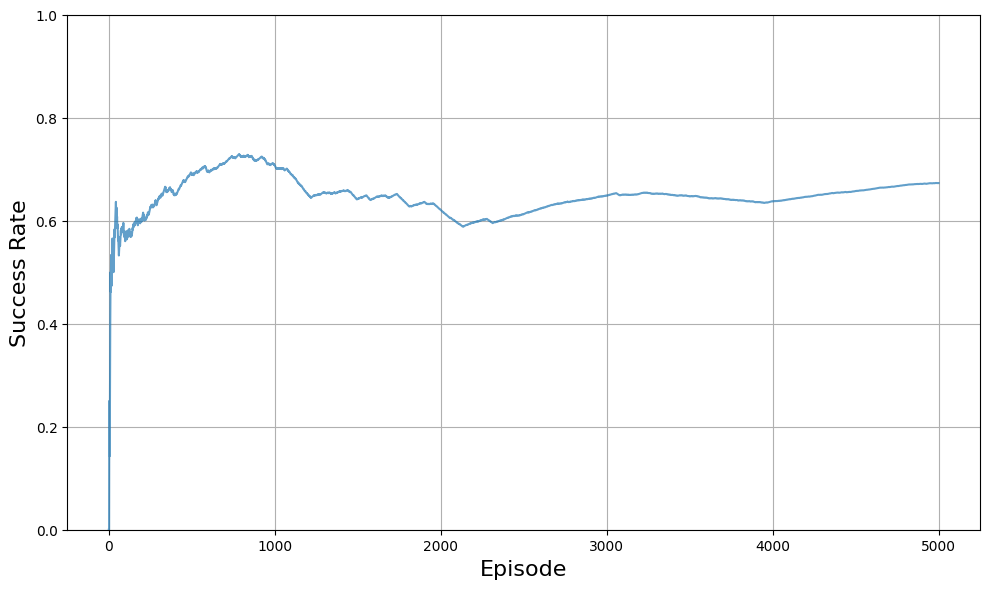

Diagnosis Success Rate: 67.28%


In [7]:
plt.figure(figsize=(10,6))
plt.plot(success_rates, alpha=0.7)
plt.xlabel("Episode", fontsize=16)
plt.ylabel("Success Rate", fontsize=16)
plt.ylim(0,1)
plt.grid(True)
plt.tight_layout()
plt.show()
print("Diagnosis Success Rate: " + str(round(success_rates[-1] * 100,2)) + "%")

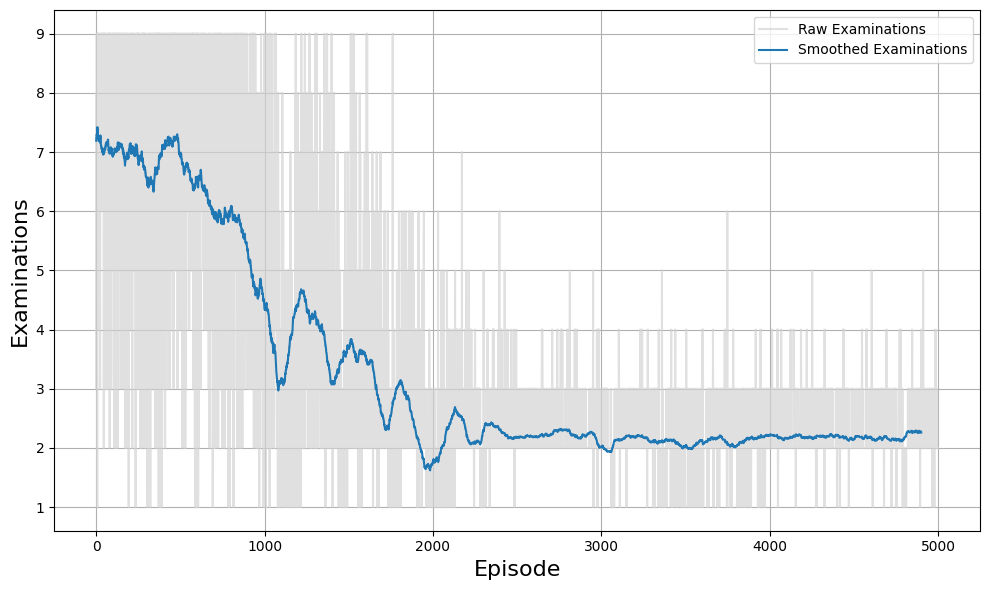

Average Examination per Diagnosis: 2.26


In [8]:
smoothed_examinations = moving_average(examinations_per_diagnosis, window_size=100)
plt.figure(figsize=(10,6))
plt.plot(examinations_per_diagnosis, color="lightgray", label="Raw Examinations", alpha=0.7)
plt.plot(range(len(smoothed_examinations)), smoothed_examinations, label="Smoothed Examinations")
plt.xlabel("Episode", fontsize=16)
plt.ylabel("Examinations", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("Average Examination per Diagnosis: " + str(round(smoothed_examinations[-1],2)))

In [9]:
df_combined = df_combined.reset_index(drop=True)
def test_agent(env, agent, num_patients=10):
    number_of_diagnoses = len(df_combined)
    print("All Departments, Number of possible Diagnosis: " + str(number_of_diagnoses))
    overall_correct_diagnoses = 0
    for num in range(number_of_diagnoses):
        correct_diagnoses = 0
        for patient_num in range(num_patients):
            state = env.set(num)
    
            exams_taken = []
            symptoms_history = []
    
            done = False
            step_count = 0
    
            while not done:
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                with torch.no_grad():
                    q_values = agent(state_tensor).squeeze()
                action = q_values.argmax().item()
                exam_taken = env.examinations[action]
    
                state, reward, done, info = env.step(action)
                observed_symptoms = env.get_observed_symptoms()
    
                exams_taken.append(exam_taken)
                symptoms_history.append(observed_symptoms)
    
                if info.get("forced", False):
                    if info["guess"] == info["diagnosis"]:
                        correct_diagnoses += 1
                        overall_correct_diagnoses += 1
                    break
    
                step_count += 1
    
        accuracy = correct_diagnoses / num_patients
        print(df_combined.loc[num,'Diagnosis'].capitalize() + " - Accuracy over " + str(num_patients) + " patients: " + str(accuracy))
    print("All Departments - Overall Accuracy: " + str(round(overall_correct_diagnoses / (num_patients * number_of_diagnoses) * 100,2)) + "%")

In [10]:
test_agent(env, agent, num_patients=100)

All Departments, Number of possible Diagnosis: 105
Ankle contusion - Accuracy over 100 patients: 1.0
Arm contusion - Accuracy over 100 patients: 1.0
Athlete's foot - Accuracy over 100 patients: 0.99
Bacterial tonsillitis - Accuracy over 100 patients: 1.0
Beef tapeworm - Accuracy over 100 patients: 0.99
Bronchitis - Accuracy over 100 patients: 1.0
Chest contusion - Accuracy over 100 patients: 0.96
Chickenpox - Accuracy over 100 patients: 1.0
Chronic fatigue syndrome - Accuracy over 100 patients: 1.0
Common cold - Accuracy over 100 patients: 0.97
Contact dermatitis - Accuracy over 100 patients: 0.96
Foot contusion - Accuracy over 100 patients: 0.96
Golfers elbow - Accuracy over 100 patients: 0.97
Hand contusion - Accuracy over 100 patients: 0.99
Hay fever - Accuracy over 100 patients: 0.98
Influenza - Accuracy over 100 patients: 1.0
Influenza b - Accuracy over 100 patients: 0.0
Insomnia - Accuracy over 100 patients: 0.84
Iron-deficiency anemia - Accuracy over 100 patients: 0.96
Lactose i

In [11]:
def test_diagnosis(env, agent, diagnosis, num_patients=5):
    int_diagnosis = int(df_combined.index[df_combined["Diagnosis"] == diagnosis].tolist()[0])
    correct_diagnoses = 0
    for patient_num in range(num_patients):
        state = env.set(int_diagnosis)

        print("\nPATIENT " + str(patient_num + 1))
        print("TRUE DIAGNOSIS: " + str(env.get_true_diagnosis()))
        print("TRUE SYMPTOMS (Generated for this patient): " + str(env.get_true_symptoms()) + "\n")

        exams_taken = []
        symptoms_history = []

        done = False
        step_count = 0

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            with torch.no_grad():
                q_values = agent(state_tensor).squeeze()
            action = q_values.argmax().item()
            exam_taken = env.examinations[action]

            state, reward, done, info = env.step(action)
            observed_symptoms = env.get_observed_symptoms()

            exams_taken.append(exam_taken)
            symptoms_history.append(observed_symptoms)

            if info.get("forced", False):
                print("\nGuessed Diagnosis: " + str(info['guess'].capitalize()))
                if info["guess"] == info["diagnosis"]:
                    correct_diagnoses += 1
                break
                
            print("Step " + str(step_count + 1))
            print("Examination taken: " + str(exam_taken))
            print("Symptoms uncovered so far: " + str(observed_symptoms))

            step_count += 1
    
    accuracy = correct_diagnoses / num_patients
    print(str(diagnosis.capitalize()) + ": Accuracy over " + str(num_patients) + " patients: " + str(accuracy))

In [12]:
test_diagnosis(env, agent, "nail fungus", 5)


PATIENT 1
TRUE DIAGNOSIS: nail fungus
TRUE SYMPTOMS (Generated for this patient): ['crumbly nail', 'nail discoloration', 'nail thickening', 'fungal infection']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['crumbly nail', 'nail discoloration', 'nail thickening']
Step 2
Examination taken: barrium swallow x ray
Symptoms uncovered so far: ['crumbly nail', 'nail discoloration', 'nail thickening']

Guessed Diagnosis: Athlete's foot

PATIENT 2
TRUE DIAGNOSIS: nail fungus
TRUE SYMPTOMS (Generated for this patient): ['crumbly nail', 'fungal infection']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['crumbly nail']
Step 2
Examination taken: blood test testing
Symptoms uncovered so far: ['crumbly nail']

Guessed Diagnosis: Athlete's foot

PATIENT 3
TRUE DIAGNOSIS: nail fungus
TRUE SYMPTOMS (Generated for this patient): ['crumbly nail', 'nail discoloration', 'nail thickening', 'fungal infection']

Step 1
Examination taken: interview
Symptoms uncovered so far:

In [14]:
test_diagnosis(env, agent, "fistula of the intestine", 5)


PATIENT 1
TRUE DIAGNOSIS: fistula of the intestine
TRUE SYMPTOMS (Generated for this patient): ['abdominal pain', 'bloating', 'dehydration', 'intestinal fistula']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['abdominal pain', 'bloating']
Step 2
Examination taken: physical and visual examination
Symptoms uncovered so far: ['abdominal pain', 'bloating', 'dehydration']
Step 3
Examination taken: spinal fluid analysis testing
Symptoms uncovered so far: ['abdominal pain', 'bloating', 'dehydration']

Guessed Diagnosis: Fistula of the intestine

PATIENT 2
TRUE DIAGNOSIS: fistula of the intestine
TRUE SYMPTOMS (Generated for this patient): ['bloating', 'dehydration', 'diarrhea', 'intestinal fistula']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['bloating', 'diarrhea']

Guessed Diagnosis: Bacterial gastroenteritis

PATIENT 3
TRUE DIAGNOSIS: fistula of the intestine
TRUE SYMPTOMS (Generated for this patient): ['bloating', 'dehydration', 'diarrhea', 'intest

In [15]:
test_diagnosis(env, agent, "penetrated pancreas laceration", 5)


PATIENT 1
TRUE DIAGNOSIS: penetrated pancreas laceration
TRUE SYMPTOMS (Generated for this patient): ['abdominal injury', 'hypovolemic shock', 'open wound', 'severe hemorrhage', 'pancreas laceration']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['abdominal injury', 'open wound', 'severe hemorrhage']
Step 2
Examination taken: blood test testing
Symptoms uncovered so far: ['abdominal injury', 'open wound', 'severe hemorrhage']

Guessed Diagnosis: Liver laceration

PATIENT 2
TRUE DIAGNOSIS: penetrated pancreas laceration
TRUE SYMPTOMS (Generated for this patient): ['abdominal injury', 'open wound', 'severe hemorrhage', 'pancreas laceration']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['abdominal injury', 'open wound', 'severe hemorrhage']
Step 2
Examination taken: blood test testing
Symptoms uncovered so far: ['abdominal injury', 'open wound', 'severe hemorrhage']

Guessed Diagnosis: Liver laceration

PATIENT 3
TRUE DIAGNOSIS: penetrated pancreas 

In [16]:
test_diagnosis(env, agent, "penetrated spleen rupture", 5)


PATIENT 1
TRUE DIAGNOSIS: penetrated spleen rupture
TRUE SYMPTOMS (Generated for this patient): ['abdominal injury', 'blood loss', 'open wound', 'severe hemorrhage', 'spleen rupture']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['abdominal injury', 'blood loss', 'open wound', 'severe hemorrhage']
Step 2
Examination taken: blood test testing
Symptoms uncovered so far: ['abdominal injury', 'blood loss', 'open wound', 'severe hemorrhage']

Guessed Diagnosis: Liver laceration

PATIENT 2
TRUE DIAGNOSIS: penetrated spleen rupture
TRUE SYMPTOMS (Generated for this patient): ['abdominal injury', 'blood loss', 'open wound', 'severe hemorrhage', 'spleen rupture']

Step 1
Examination taken: interview
Symptoms uncovered so far: ['abdominal injury', 'blood loss', 'open wound', 'severe hemorrhage']
Step 2
Examination taken: blood test testing
Symptoms uncovered so far: ['abdominal injury', 'blood loss', 'open wound', 'severe hemorrhage']

Guessed Diagnosis: Liver laceration

PAT